# NOTEBOOK FOR DEFENSE TECHNQUES

In [1]:
%run Chinese_MNIST_preprocessing.ipynb


Skipping, found downloaded files in ".\chinese-mnist" (use force=True to force download)


In [2]:
# import of libraries
import torch
import torch.nn as nn
import torch.optim as optim


# 1. ADVERSARIAL TRAINING

In [3]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculez la taille de la première couche linéaire en fonction de la sortie des couches de convolution
        self.fc1_input_size = 32 * 16 * 16  # 32 canaux, 16x16 taille après max-pooling

        self.classifier = nn.Sequential(
            nn.Linear(self.fc1_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1) 
        x = self.classifier(x)
        return x

# Créer une instance du modèle
model = CNNModel(num_classes=15)

# Afficher le modèle
print(model)


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=15, bias=True)
  )
)


In [4]:
def prepare_set_data(set_set):
    set_images = []
    set_labels = []

    # Séparer les étiquettes et les images de l'ensemble de données
    for i in range(len(set_set)):
        set_images.append(set_set[i][0])
        set_labels.append(int(set_set[i][1][-2:]) - 1)  # Soustraire 1 ici (donc 0 correspond à 01, 1 à 02, etc.)

    set_img_tensors = torch.tensor(set_images, dtype=torch.float32).permute(0, 3, 1, 2)
    set_labels = torch.tensor(set_labels, dtype=torch.long)

    return set_img_tensors, set_labels


test_img_tensors, test_labels = prepare_set_data(test_set)
train_img_tensors, train_labels = prepare_set_data(train_set)


C:\Users\choho\AppData\Local\Temp\ipykernel_29304\1652656436.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  set_img_tensors = torch.tensor(set_images, dtype=torch.float32).permute(0, 3, 1, 2)


In [5]:
# put into dataloader because we will use mini-batch gradient descent
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_img_tensors, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

test_dataset = TensorDataset(test_img_tensors, test_labels)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# training

In [24]:
# Fonction d'entraînement
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return {'output': outputs,  # Pour afficher les prédictions sur le dernier lot
        'train_loss': total_loss / len(dataloader),
        'train_acc': total_correct / total_samples,
    }

# Fonction de validation
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            
    return {'output': outputs,  # Pour afficher les prédictions sur le dernier lot
        'val_loss': total_loss / len(dataloader),
        'val_acc': total_correct / total_samples,
    }

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Entraînement et évaluation du modèle sur plusieurs époques
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Define the optimizer


# Entraînement et évaluation du modèle sur plusieurs époques

for epoch in range(num_epochs):
    train_result = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_result = validate_one_epoch(model, test_loader, loss_fn, device)

    # Affichage des résultats pour chaque époque
    print(f'Époque {epoch+1}/{num_epochs}')
    print(f'Entraînement - Perte: {train_result["train_loss"]:.4f}, Accuracy: {train_result["train_acc"]:.4f}')
    print(f'Validation - Perte: {val_result["val_loss"]:.4f}, Accuracy: {val_result["val_acc"]:.4f}')



# sauvegarder le modèle
torch.save(model.state_dict(), 'baseline_model.pth')

# charger le modèle
model = CNNModel(num_classes=15)
model.load_state_dict(torch.load('baseline_model.pth'))
model.eval()



Époque 1/50
Entraînement - Perte: 0.0443, Accuracy: 0.9876
Validation - Perte: 0.4642, Accuracy: 0.9553
Époque 2/50
Entraînement - Perte: 0.0222, Accuracy: 0.9939
Validation - Perte: 0.4039, Accuracy: 0.9570
Époque 3/50
Entraînement - Perte: 0.0091, Accuracy: 0.9979
Validation - Perte: 0.3336, Accuracy: 0.9617
Époque 4/50
Entraînement - Perte: 0.0048, Accuracy: 0.9990
Validation - Perte: 0.3105, Accuracy: 0.9680
Époque 5/50
Entraînement - Perte: 0.0007, Accuracy: 1.0000
Validation - Perte: 0.2990, Accuracy: 0.9680
Époque 6/50
Entraînement - Perte: 0.0004, Accuracy: 1.0000
Validation - Perte: 0.3010, Accuracy: 0.9677
Époque 7/50
Entraînement - Perte: 0.0003, Accuracy: 1.0000
Validation - Perte: 0.3007, Accuracy: 0.9680
Époque 8/50
Entraînement - Perte: 0.0003, Accuracy: 1.0000
Validation - Perte: 0.3028, Accuracy: 0.9677
Époque 9/50
Entraînement - Perte: 0.0003, Accuracy: 1.0000
Validation - Perte: 0.3035, Accuracy: 0.9677
Époque 10/50
Entraînement - Perte: 0.0002, Accuracy: 1.0000
Vali

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=15, bias=True)
  )
)

In [16]:
def get_all_predictions(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


In [25]:
# Utiliser la fonction pour obtenir les prédictions sur l'ensemble de données de test
test_predictions, test_labels = get_all_predictions(model, test_loader, device)

# Afficher les prédictions et les étiquettes réelles
print("Prédictions:", test_predictions)
print("Étiquettes réelles:", test_labels)

Prédictions: [11, 14, 9, 3, 9, 2, 4, 6, 9, 4, 8, 1, 11, 11, 7, 12, 13, 5, 1, 6, 14, 3, 11, 2, 14, 11, 10, 14, 1, 2, 7, 14, 9, 12, 3, 3, 5, 10, 13, 6, 7, 0, 6, 6, 2, 5, 12, 13, 1, 3, 6, 2, 9, 0, 14, 12, 0, 7, 8, 10, 13, 12, 8, 14, 3, 5, 7, 3, 2, 11, 12, 14, 1, 10, 4, 1, 3, 1, 11, 12, 2, 2, 7, 8, 4, 14, 0, 5, 4, 4, 12, 10, 0, 7, 14, 2, 0, 10, 14, 8, 5, 8, 5, 2, 3, 1, 1, 2, 9, 0, 13, 10, 1, 3, 9, 3, 4, 7, 13, 12, 11, 0, 5, 11, 2, 11, 2, 4, 7, 12, 11, 7, 9, 12, 3, 3, 5, 5, 8, 5, 3, 1, 0, 0, 9, 9, 14, 11, 9, 14, 4, 14, 1, 8, 2, 5, 3, 11, 13, 7, 5, 2, 10, 12, 11, 13, 13, 11, 12, 4, 11, 3, 14, 13, 8, 0, 8, 0, 3, 10, 4, 3, 7, 9, 1, 12, 0, 7, 8, 8, 14, 12, 11, 3, 3, 1, 5, 6, 7, 12, 6, 7, 6, 12, 6, 1, 12, 1, 11, 10, 11, 9, 9, 0, 11, 8, 5, 1, 6, 1, 6, 6, 13, 5, 4, 1, 4, 11, 2, 11, 5, 0, 9, 0, 6, 1, 12, 4, 11, 14, 3, 6, 8, 3, 5, 7, 0, 11, 13, 6, 14, 7, 1, 14, 8, 11, 14, 1, 11, 13, 2, 7, 5, 12, 9, 10, 6, 8, 8, 1, 2, 9, 14, 10, 4, 2, 11, 9, 14, 3, 10, 10, 13, 9, 7, 0, 3, 5, 13, 14, 7, 0, 5, 14, 14, 

# Fast Sign Gradient Methods

In [26]:
# Importation des bibliothèques nécessaires
import torch
import torch.nn.functional as F

# Définition de la fonction FGSM
def FGSM(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Paramètre de l'attaque
epsilon = 0.01

# Charger les données de test
test_img_tensors, test_labels = prepare_set_data(test_set)
test_img_tensors.requires_grad = True

# Passer les images dans le modèle et calculer les pertes
outputs = model(test_img_tensors.to(device))
loss = F.cross_entropy(outputs, test_labels.to(device))

# Remettre à zéro les gradients existants dans le modèle et effectuer la rétropropagation
model.zero_grad()
loss.backward()

# Collecter les gradients par rapport aux images d'entrée
data_grad = test_img_tensors.grad.data

# Appliquer FGSM sur les images de test
perturbed_data_test = FGSM(test_img_tensors, epsilon, data_grad)

# Évaluer le modèle sur les images adverses
output = model(perturbed_data_test.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())



Test accuracy on adversarial images: 0.6466666460037231


In [19]:
# Charger les données d'entraînement
train_img_tensors, train_labels = prepare_set_data(train_set)
train_img_tensors.requires_grad = True

# Passer les images d'entraînement dans le modèle et calculer les pertes
outputs_train = model(train_img_tensors.to(device))
loss_train = F.cross_entropy(outputs_train, train_labels.to(device))

# Remettre à zéro les gradients existants dans le modèle et effectuer la rétropropagation pour les images d'entraînement
model.zero_grad()
loss_train.backward()

# Collecter les gradients par rapport aux images d'entraînement
data_grad_train = train_img_tensors.grad.data

# Appliquer FGSM sur les images d'entraînement
perturbed_data_train = FGSM(train_img_tensors, epsilon, data_grad_train)

# Évaluer le modèle sur les images adverses d'entraînement
output_train = model(perturbed_data_train.to(device))
final_loss_train = F.cross_entropy(output_train, train_labels.to(device))
final_acc_train = (output_train.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTraining accuracy on adversarial images:', final_acc_train.item())



Training accuracy on adversarial images: 0.5400833487510681


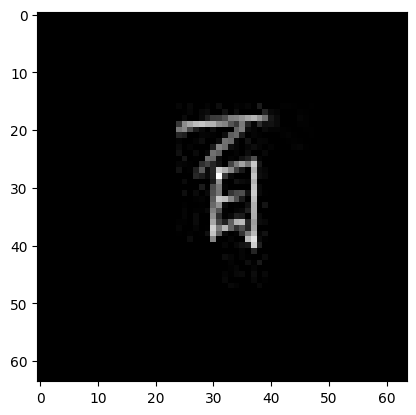

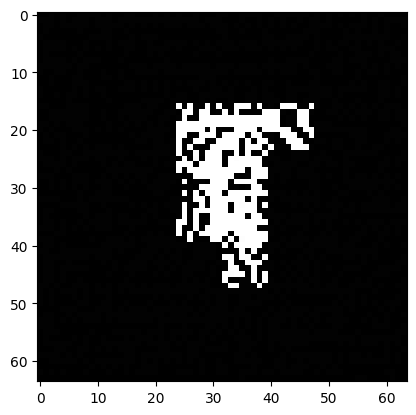

In [20]:
#affiche une image avant et après pertubation
import matplotlib.pyplot as plt
import numpy as np

# Définition de la fonction pour afficher une image
def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Définition de la fonction pour afficher une image avant et après perturbation
def show_images(image, perturbed_image):
    img = image[0]
    perturbed_img = perturbed_image[0]
    imshow(img.cpu())
    imshow(perturbed_img.cpu())

# Afficher une image avant et après perturbation
show_images(test_img_tensors, perturbed_data_test)


# APPLY DEFENSE

In [21]:
def adversarial_training(model, train_loader, epsilon, optimizer, loss_fn, device, num_epochs):
    for epoch in range(num_epochs):
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Création d'exemples adverses avec FGSM
            images.requires_grad = True
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            perturbed_images = FGSM(images, epsilon, data_grad)

            # Entraînement avec les données originales
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Entraînement avec les données adverses
            optimizer.zero_grad()
            outputs_adv = model(perturbed_images)
            loss_adv = loss_fn(outputs_adv, labels)
            loss_adv.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} completed.")
    return model

# Paramètres
epsilon = 0.1  # Paramètre pour FGSM
num_epochs = 5  # Nombre d'époques pour l'entraînement
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Entraînement adversarial
model_robust_1 = adversarial_training(model, train_loader, epsilon, optimizer, loss_fn, device, num_epochs)

#sauvegarder le modèle
torch.save(model_robust_1.state_dict(), 'model_robust_1.pth')




Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.


In [22]:
# charger le modèle
#model_robust_1 = CNNModel(num_classes=15)
#model_robust_1.load_state_dict(torch.load('model_robust_1.pth'))
#model_robust_1.eval()

# Évaluer le modèle robuste sur les images adverses
output = model_robust_1(perturbed_data_test.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())



Test accuracy on adversarial images: 0.671999990940094


In [23]:
# charger le modèle
#model_robust_1 = CNNModel(num_classes=15)
#model_robust_1.load_state_dict(torch.load('model_robust_1.pth'))
#model_robust_1.eval()

# Évaluer le modèle robuste sur les images adverses
output = model_robust_1(perturbed_data_train.to(device))
final_loss = F.cross_entropy(output, train_labels.to(device))
final_acc = (output.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())



Test accuracy on adversarial images: 0.6723333597183228
